# Import

In [1]:
import pandas as pd
from scipy.stats import skew
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition, cluster, metrics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import folium

On importe les différentes librairies nécessaires.

In [2]:
df = pd.read_csv("./data/analyse/data_analyse.csv")
df = df.set_index('Zone')

# Analyse en composantes principales

Une analyse en composantes principales va nous permettre de mettre réduire le nombre de variable un nombre de composantes moins élevé pour résumer l'information.

In [3]:
X = df.values

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

pca = decomposition.PCA()
pca.fit(X_scaled)

PCA()

Ici on entraine notre algorithme sur nos données.

In [4]:
print('Variance expliquée pour chaque composantes :', pca.explained_variance_ratio_)
print('Variance expliquée cumulée pour les composantes :', pca.explained_variance_ratio_.cumsum())

Variance expliquée pour chaque composantes : [0.36171305 0.19318871 0.13495481 0.09670525 0.08705034 0.07294394
 0.03020547 0.02323843]
Variance expliquée cumulée pour les composantes : [0.36171305 0.55490176 0.68985657 0.78656182 0.87361216 0.94655609
 0.97676157 1.        ]


La variance exlpiqué des composantes nous permet de définir le nombre de composantes principales nécessaire pour expliquer au mieux notre jeu de données. Par exemple 2 composantes nous permettent ici d'expliquer environ 55% de nos données, 3 composantes nous permettent d'expliquer 69% et ainsi de suite.

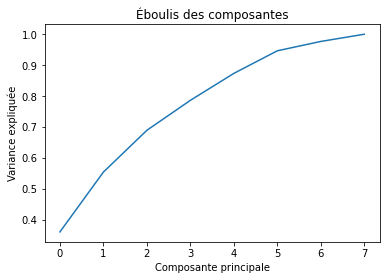

In [5]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Éboulis des composantes')
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée')
plt.show()

Une autre façon d'affiché la variances expliquées des composantes.

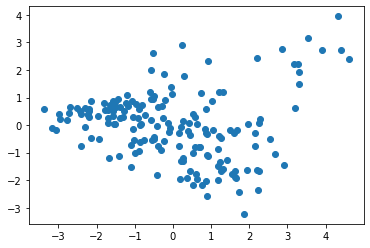

In [6]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1])

Voici la projection de nos points sur les 2 premiers axe de composantes principales.

(-0.7, 0.7)

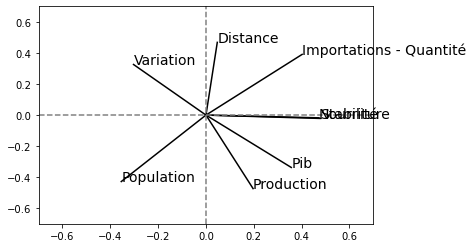

In [7]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, df.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

Le cercle de corrélation nous permet de comprendre le liens entre les composantes principale et nos variables. Ici on voit que la première compsante est fortement corrélé à la Stabilité et à la Nourriture par habitant alors que la deuxième composante est plutôt corrélé à la distance avec la France ou à la production par habitant dans une moindre mesure.
On peut aussi déduire que plus un pays à de fortes importations par habitant moins il à de population, ces deux variables sont donc inversement corrélé. Ou encore le Pib par habitant qui est inversement corrélé à la variation de la population.

# Clustering

Le but du clustering est de créer des groupes, ici de pays, qui partage des caractèristiques similaires.

## K-Means

K-means est un algorithme de clustering.

[0.25496709402431383, 0.24537611062384515, 0.1708707992243381, 0.20819283861401566, 0.1930464284022946, 0.21025410550517104, 0.20854713793818844, 0.20834656672902535]


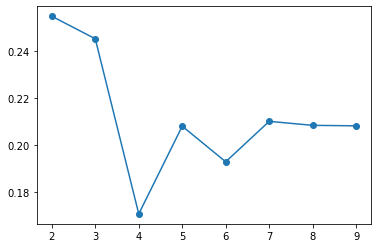

In [8]:
silhouettes = []

for num_clusters in range(2, 10):
  cls = cluster.KMeans(n_clusters=num_clusters, n_init=1, init='random')
  cls.fit(X_scaled)
  silh = metrics.silhouette_score(X_scaled, cls.labels_)
  silhouettes.append(silh)

print(silhouettes)
plt.plot(range(2,10), silhouettes, marker="o")

Ici on entraine notre algorithme de clustering et on trace un graphique qui nous permet de determiner le nombre de clusters idéal dans notre cas, ici il semble que 3 clusters soit l'idéal. Étant donnés que l'algorithme s'entraine "tout seul" nous n'auront pas forcement les mêmes résultats exactements à chaques itérations.

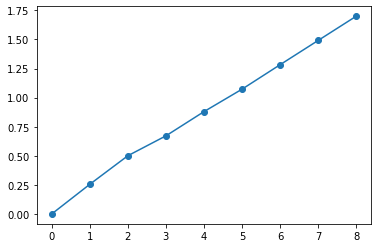

In [9]:
arr = [0]

for i in range(0,len(silhouettes)):
  x = arr[i] + silhouettes[i]
  arr.append(x)

plt.plot(arr, marker="o")

array([0, 2, 3, 0, 3, 0, 1, 2, 2, 0, 2, 3, 0, 1, 0, 2, 3, 2, 2, 3, 0, 2,
       3, 0, 3, 0, 3, 0, 0, 3, 2, 1, 1, 2, 0, 3, 2, 0, 2, 3, 3, 0, 3, 2,
       1, 2, 3, 3, 0, 2, 3, 3, 3, 0, 0, 0, 1, 3, 0, 0, 0, 2, 3, 0, 0, 3,
       0, 0, 0, 0, 3, 3, 2, 3, 2, 3, 0, 0, 0, 0, 2, 2, 0, 3, 0, 0, 3, 3,
       3, 0, 2, 0, 2, 0, 3, 0, 2, 0, 2, 0, 3, 0, 2, 0, 2, 0, 0, 3, 1, 2,
       0, 0, 0, 0, 0, 2, 0, 3, 0, 3, 1, 3, 2, 3, 3, 0, 0, 3, 3, 2, 0, 0,
       0, 1, 1, 1, 1, 0, 3, 0, 3, 3, 0, 0, 3, 2, 3, 0, 0, 0, 3, 0, 0, 0,
       2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0], dtype=int32)

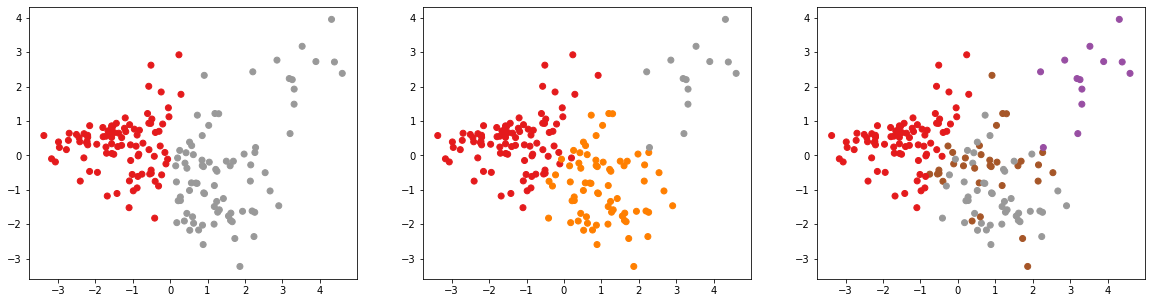

In [10]:
fig = plt.figure(figsize=(20,5))

cls = cluster.KMeans(n_clusters=2)
cls.fit(X_scaled)
ax = fig.add_subplot(131)
ax.scatter(X_projected[:, 0], X_projected[:, 1], c=cls.labels_, cmap='Set1')

cls3 = cluster.KMeans(n_clusters=3)
cls3.fit(X_scaled)
ax = fig.add_subplot(132)
ax.scatter(X_projected[:, 0], X_projected[:, 1], c=cls3.labels_, cmap='Set1')

cls4 = cluster.KMeans(n_clusters=4)
cls4.fit(X_scaled)
ax = fig.add_subplot(133)
ax.scatter(X_projected[:, 0], X_projected[:, 1], c=cls4.labels_, cmap='Set1')

cls4.labels_

On entraine notre algorithme K-means avec un nombre de cluster différent, ici 2, 3 et 4 cluster et on projète nos pays sur nos axe de composantes principale en les colorisant en fonction du cluster auquel ils appartienent. On voit visuellement que 3 clusters semble être le nombre de cluster idéal comme on l'a vu plus tôt.

In [11]:
data_k = pd.DataFrame(X_scaled)
data_k.columns = df.columns
data_k['cluster'] = cls3.labels_
data_k['Zone'] = df.index
data = pd.melt(frame=data_k, id_vars=['cluster', 'Zone'])

,cluster,Zone,variable,value
0,0,Afghanistan,Importations - Quantité,-0.545071
1,0,Afrique du Sud,Importations - Quantité,-0.101974
2,1,Albanie,Importations - Quantité,0.122317
3,0,Algérie,Importations - Quantité,-0.585550
4,1,Allemagne,Importations - Quantité,-0.038856
...,...,...,...,...
1371,2,Émirats arabes unis,Stabilité,0.764383
1372,0,Équateur,Stabilité,-0.009653
1373,1,États-Unis d'Amérique,Stabilité,0.450282
1374,0,Éthiopie,Stabilité,-1.815736


On réassocie le nom des pays à ces valeurs et on modifie le tableau pour pouvoir afficher un boxplot (ou boite à moustache) pour pouvoir caractériser les clusters.

<AxesSubplot:xlabel='value', ylabel='variable'>

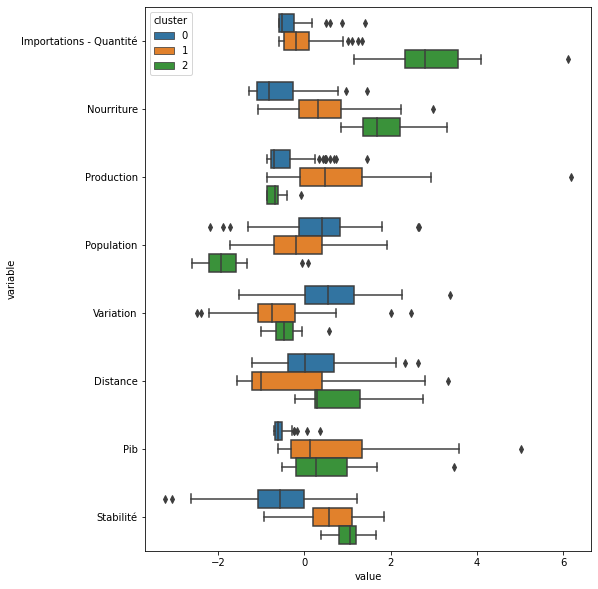

In [12]:
plt.figure(figsize=(8,10))
sns.boxplot(data=data, y='variable', x='value', hue='cluster')

In [13]:
data2 = data[['cluster', 'variable', 'value']].groupby(['cluster', 'variable']).mean().reset_index()
data2 = pd.pivot_table(data2, index='cluster', columns='variable', values='value')

On modifie à nouveau le tableau pour pouvoir afficher une heatmap toujours pour pouvoir caractériser les clusters.

<AxesSubplot:xlabel='variable', ylabel='cluster'>

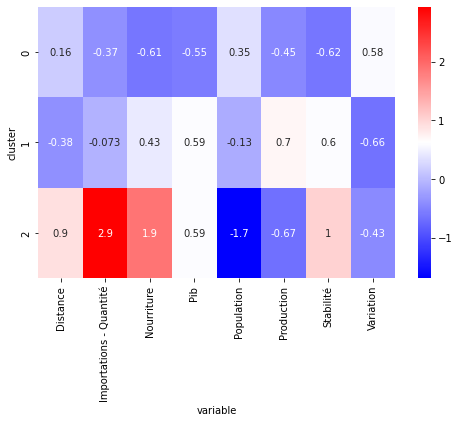

In [14]:
plt.figure(figsize=(8,5))
sns.heatmap(data2, cmap="bwr", annot=True)

Grâce aux deux graphiques qu'on à tracé on voit que sur les trois clusters l'un d'eux contient plutôt des pays lointain mais fortement importateur de poulet avec une population faible et qui semble manger beaucoup de poulet, ils ont aussi un Pib par habitant assez élevé. C'est le cluster qui nous interessent.

Un autre cluster semble plutôt contenir des pays qui ont un Pib par habitant élevé, qui sont proche de la France et qui ont variation de population basse voir négative.

Enfin le dernier cluster contient des pays dont la population mange peu de poulet et qui en importe peu, pour qui la population est en hausse mais qui ont une failbe stabilité politique. Ils ont également un faible Pib dans l'ensemble.

Le boxplot nous permet de voir plus précisement si par exemple tous les pays du cluster ont un faible Pib ou si ils sont dispercé, etc...

## Classification ascendante hiérarchique

La classification ascendante hiérarchique est un autre algorithme de clustering qui permet de créer un dendrograme (un arbre). L'avantage de cet algorithme est qu'il permet de choisir le nombre de cluster après classification, il n'y a pas besoin de choisir avant.

{'icoord': [[35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [15.0, 15.0, 32.5, 32.5],
  [5.0, 5.0, 23.75, 23.75],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [85.0, 85.0, 95.0, 95.0],
  [105.0, 105.0, 115.0, 115.0],
  [90.0, 90.0, 110.0, 110.0],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [125.0, 125.0, 142.5, 142.5],
  [100.0, 100.0, 133.75, 133.75],
  [62.5, 62.5, 116.875, 116.875],
  [175.0, 175.0, 185.0, 185.0],
  [195.0, 195.0, 205.0, 205.0],
  [180.0, 180.0, 200.0, 200.0],
  [165.0, 165.0, 190.0, 190.0],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [177.5, 177.5, 222.5, 222.5],
  [89.6875, 89.6875, 200.0, 200.0],
  [14.375, 14.375, 144.84375, 144.84375],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [275.0, 275.0, 285.0, 285.0],
  [305.0, 305.0, 315.0, 315.0],
  [295.0, 295.0, 310.0, 310.0],
  [280.0, 280.0, 302.5, 302.5],
  [252.5, 252.5, 291.25, 291.25],
  [325.0, 325.0, 335.0, 335.0],
  [355.0

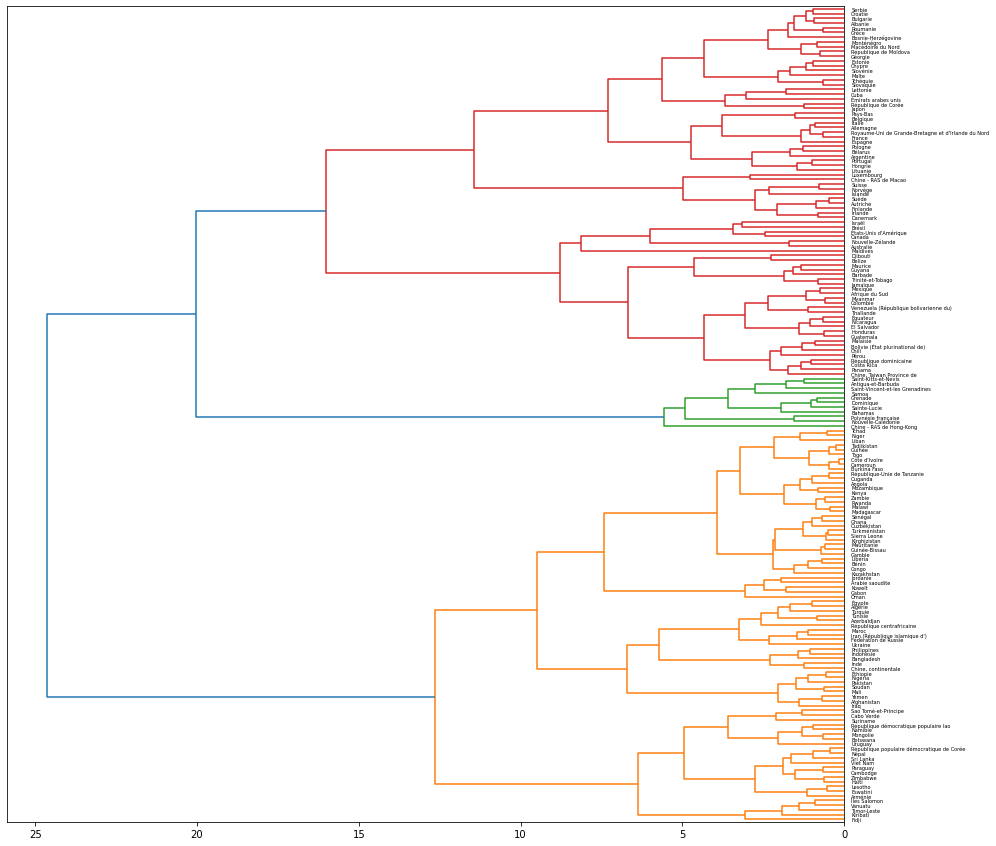

In [15]:
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(15,15))
dendrogram(Z, orientation='left', labels=df.index)

On crée donc notre arbre qui nous permet de voir directement quel sont les clusters. Cela permet une classification plus visuel.

In [16]:
data_h = pd.DataFrame(X_scaled)
data_h.columns = df.columns
data_h['cluster'] = fcluster(Z, t=3, criterion='maxclust')
data_h['Zone'] = df.index
data = pd.melt(frame=data_h, id_vars=['cluster', 'Zone'])

De la même façon que pour l'algorithme K-means on modifie notre jeu de données pour pouvoir analyser les clusters et les caractériser.

<AxesSubplot:xlabel='value', ylabel='variable'>

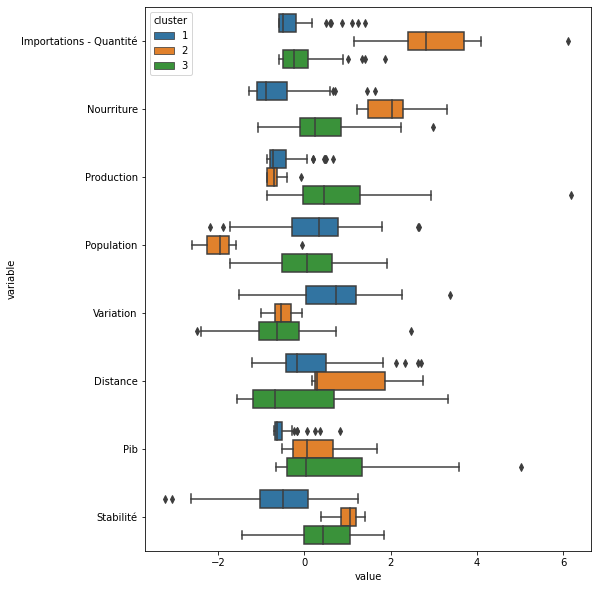

In [17]:
plt.figure(figsize=(8,10))
sns.boxplot(data=data, y='variable', x='value', hue='cluster')

In [18]:
data2 = data[['cluster', 'variable', 'value']].groupby(['cluster', 'variable']).mean().reset_index()
data2 = pd.pivot_table(data2, index='cluster', columns='variable', values='value')

<AxesSubplot:xlabel='variable', ylabel='cluster'>

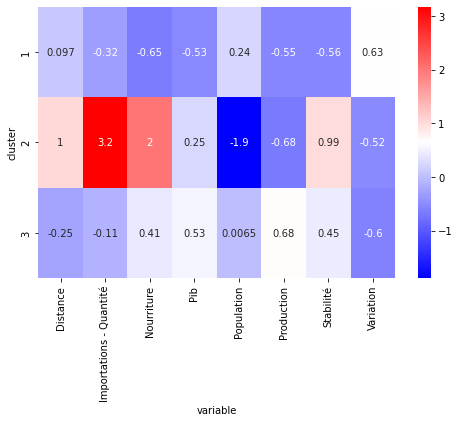

In [19]:
plt.figure(figsize=(8,5))
sns.heatmap(data2, cmap="bwr", annot=True)

On retrouve à nouveau les clusters qu'on à eu avec l'algorithme K-means, avec quand même quelques différences, on voit par exemple que le cluster qui nous intéresse à des importations plus élevé ici et un pib moyen plus faible. Les valeurs semblent plus extrême pour le cluster intéressant ce qui pourrait signifier que les pays qu'il contient sont déjà un peu filtrer par rapport au résultats de l'algorithme K-means.

# Résultats

### Cluster K-means

On va maintenant chercher à l'intérieur des 2 clusters retenu quel sont les pays les plus intéressants pour exporter du poulet.

In [20]:
pays_k = data_k.loc[data_k['cluster'] == 2]
pays_k

,Importations - Quantité,Nourriture,Production,Population,Variation,Distance,Pib,Stabilité,cluster,Zone
6,3.367474,2.026835,-0.862621,-2.289803,-0.173881,1.283075,0.071774,0.910216,2,Antigua-et-Barbuda
13,2.801931,1.365201,-0.077974,-1.574601,-0.263469,0.294744,0.952113,1.179446,2,Bahamas
31,6.105954,2.097428,-0.698630,-0.051931,-0.481040,0.918370,1.694449,0.999959,2,Chine - RAS de Hong-Kong
32,1.403955,0.848929,-0.622057,-1.322294,0.572579,0.554953,3.473442,1.673034,2,Chine - RAS de Macao
44,2.430360,1.369682,-0.862621,-2.439011,-0.996197,0.196426,-0.347686,1.415022,2,Dominique
56,2.816339,1.566156,-0.412346,-2.212402,-0.563777,0.272095,-0.199206,1.201882,2,Grenade
108,1.162948,1.224985,-0.682488,-1.739790,-0.048776,2.743951,0.989686,0.382974,2,Nouvelle-Calédonie
120,2.341429,1.691594,-0.681804,-1.741744,-0.657185,2.478852,0.369358,0.382974,2,Polynésie française
133,3.556279,2.357864,-0.862621,-2.602539,-0.373911,0.178924,0.267190,0.798037,2,Saint-Kitts-et-Nevis
134,3.830781,3.316998,-0.862621,-2.217297,-0.892222,0.239150,-0.351512,1.067267,2,Saint-Vincent-et-les Grenadines


D'abord on affiche les pays du cluster qui nous intéresse.

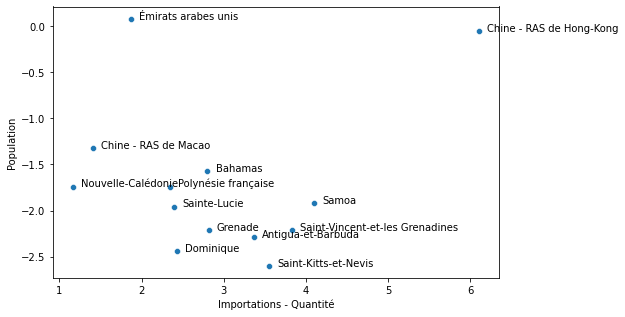

In [21]:
plt.figure(figsize=(8,5))

sns.scatterplot(data=pays_k, x=pays_k['Importations - Quantité'], y=pays_k['Population'])

a = pd.concat({'x': pays_k['Importations - Quantité'], 'y': pays_k['Population'], 'val': pays_k['Zone']}, axis=1)
for i, point in a.iterrows():
    plt.text(point['x']+.1, point['y'], str(point['val']))

Ensuite on fait un nuage de points avec en absisse la quantité d'importation par habitant et en ordonné la quantité de population.

On peut voir un pays se démarquer largement à savoir Honk-Kong qui en plus d'avoir une forte population importent fortement. Les Émirats-arabes-unis semblent aussi être une options intéressante car ils importent un peu moins que les autres pays de ce cluster mais reste de gros importateurs et ont une forte population.

D'autre pays peuvent être intéressant comme par exemple les Samoa et les Bahamas.

#### Distance

Ici on va chercher à voir, dans le cluster contenant des pays proches, quel sont les pays qui importe le plus de poulet.

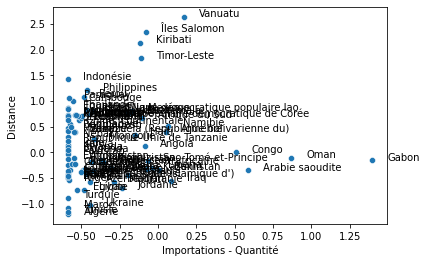

In [22]:
cluster_proche = data_k.loc[data_k['cluster'] == 0]

sns.scatterplot(data=cluster_proche, x=cluster_proche['Importations - Quantité'], y=cluster_proche['Distance'])

a = pd.concat({'x': cluster_proche['Importations - Quantité'], 'y': cluster_proche['Distance'], 'val': cluster_proche['Zone']}, axis=1)
for i, point in a.iterrows():
    plt.text(point['x']+.1, point['y'], str(point['val']))

In [23]:
cluster_proche.sort_values('Importations - Quantité', ascending=False).head()

,Importations - Quantité,Nourriture,Production,Population,Variation,Distance,Pib,Stabilité,cluster,Zone
53,1.396637,0.584661,-0.765908,-0.703820,1.627340,-0.159785,-0.350604,-0.043306,0,Gabon
111,0.868030,0.086384,-0.787723,-0.283269,3.385912,-0.114229,0.058673,0.910216,0,Oman
7,0.588036,1.456084,0.066442,0.727445,1.025936,-0.350760,0.352518,-0.581766,0,Arabie saoudite
37,0.509175,0.078635,-0.794241,-0.236301,0.994956,-0.003042,-0.613568,-0.525676,0,Congo
160,0.167324,-0.616511,-0.687763,-1.724460,1.150339,2.637912,-0.565505,0.854126,0,Vanuatu


Dans ce cluster on peut donc s'intéresser aux Pays-Bas ou à la Belgique qui sont moins importateur que les pays du cluster précédent mais aussi beaucoup plus proche.

### Cluster CAH

In [24]:
pays_h = data_h.loc[data_h['cluster'] == 2]
pays_h

,Importations - Quantité,Nourriture,Production,Population,Variation,Distance,Pib,Stabilité,cluster,Zone
6,3.367474,2.026835,-0.862621,-2.289803,-0.173881,1.283075,0.071774,0.910216,2,Antigua-et-Barbuda
13,2.801931,1.365201,-0.077974,-1.574601,-0.263469,0.294744,0.952113,1.179446,2,Bahamas
31,6.105954,2.097428,-0.698630,-0.051931,-0.481040,0.918370,1.694449,0.999959,2,Chine - RAS de Hong-Kong
44,2.430360,1.369682,-0.862621,-2.439011,-0.996197,0.196426,-0.347686,1.415022,2,Dominique
56,2.816339,1.566156,-0.412346,-2.212402,-0.563777,0.272095,-0.199206,1.201882,2,Grenade
108,1.162948,1.224985,-0.682488,-1.739790,-0.048776,2.743951,0.989686,0.382974,2,Nouvelle-Calédonie
120,2.341429,1.691594,-0.681804,-1.741744,-0.657185,2.478852,0.369358,0.382974,2,Polynésie française
133,3.556279,2.357864,-0.862621,-2.602539,-0.373911,0.178924,0.267190,0.798037,2,Saint-Kitts-et-Nevis
134,3.830781,3.316998,-0.862621,-2.217297,-0.892222,0.239150,-0.351512,1.067267,2,Saint-Vincent-et-les Grenadines
135,2.391844,2.207692,-0.586729,-1.959709,-0.691796,0.239150,-0.153520,1.179446,2,Sainte-Lucie


On affiche cette fois le cluster trouvé grâce à l'algorithme de CAH.

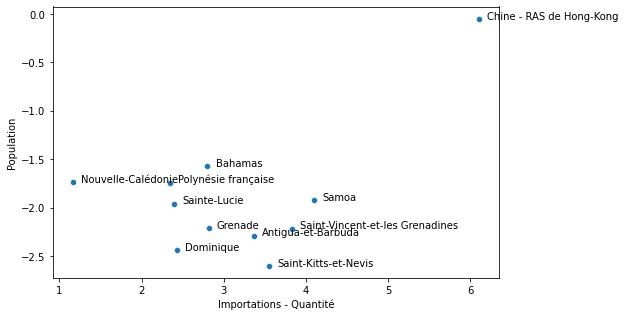

In [25]:
plt.figure(figsize=(8,5))

sns.scatterplot(data=pays_h, x=pays_h['Importations - Quantité'], y=pays_h['Population'])

a = pd.concat({'x': pays_h['Importations - Quantité'], 'y': pays_h['Population'], 'val': pays_h['Zone']}, axis=1)
for i, point in a.iterrows():
    plt.text(point['x']+.1, point['y'], str(point['val']))

Et on affiche à nouveau les données dans un nuage de point. On voit que les Émirat-arabes-unis ne font pas parti du cluster, ce qui peut expliquer les différences de valeurs moyenne trouvé dans la heatmap.

Mais il semble que les pays qui se démarquais plus haut se démarques toujours ici.

#### Distance - Importations

Ici on va chercher à voir, dans le cluster contenant des pays proches, quel sont les pays qui importe le plus de poulet.

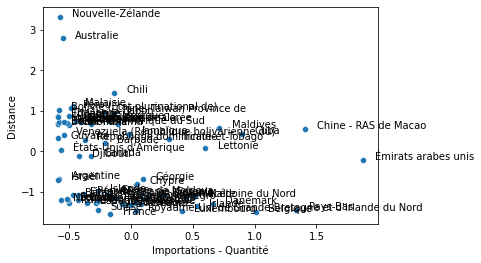

In [26]:
cluster_proche = data_h.loc[data_h['cluster'] == 3]

sns.scatterplot(data=cluster_proche, x=cluster_proche['Importations - Quantité'], y=cluster_proche['Distance'])

a = pd.concat({'x': cluster_proche['Importations - Quantité'], 'y': cluster_proche['Distance'], 'val': cluster_proche['Zone']}, axis=1)
for i, point in a.iterrows():
    plt.text(point['x']+.1, point['y'], str(point['val']))

In [27]:
cluster_proche.sort_values('Importations - Quantité', ascending=False).head()

,Importations - Quantité,Nourriture,Production,Population,Variation,Distance,Pib,Stabilité,cluster,Zone
167,1.872971,1.460817,-0.610034,0.082814,-0.464564,-0.209202,1.380487,0.764383,3,Émirats arabes unis
32,1.403955,0.848929,-0.622057,-1.322294,0.572579,0.554953,3.473442,1.673034,3,Chine - RAS de Macao
117,1.338012,0.003159,2.363692,0.384346,-0.877657,-1.445130,1.812807,1.100920,3,Pays-Bas
16,1.007887,-0.483853,1.161480,0.178454,-0.593235,-1.487855,1.555652,0.551243,3,Belgique
40,0.895573,0.217426,-0.734941,0.174805,-0.989976,0.426521,-0.282699,0.798037,3,Cuba


On voit donc que dans ce cluster les Émirats arabes unis apparaissent être interessant car ils sont fortement importateur et moins loin que Hong-Kong par exemple. On peut faire encore plus proche avec par exemple les Pays Bas ou la Belgique.

# Cartes

## K-Means

In [28]:
pays = pd.read_csv("./data/folium/coord.csv", sep=';')

pays = pd.merge(pays, data_k[['Zone', 'cluster']], left_on='pays', right_on='Zone', how='inner')
pays = pays[['pays', 'Lat', 'Long', 'cluster']]
pays['color'] = np.where(pays['cluster'] == 1, 'green', 'blue')
pays['color'] = np.where(pays['cluster'] == 2, 'red', pays['color'])
pays

,pays,Lat,Long,cluster,color
0,Afghanistan,33.930445,67.678945,0,blue
1,Afrique du Sud,-28.483220,24.676997,0,blue
2,Albanie,41.156986,20.181222,1,green
3,Algérie,28.026875,1.652840,0,blue
4,Allemagne,51.165706,10.452764,1,green
...,...,...,...,...,...
159,Égypte,26.696361,30.246486,0,blue
160,Émirats arabes unis,24.358745,53.982494,2,red
161,Équateur,-1.779901,-78.131592,0,blue
162,Éthiopie,9.148086,40.493059,0,blue


In [29]:
world = folium.Map()

for indice, row in pays.iterrows():
    folium.Marker(
        location=[row["Lat"], row["Long"]],
        popup=row['pays'],
        icon=folium.map.Icon(color=row['color'])
    ).add_to(world)

world

## CAH

In [30]:
pays = pd.read_csv("./data/folium/coord.csv", sep=';')

pays = pd.merge(pays, data_h[['Zone', 'cluster']], left_on='pays', right_on='Zone', how='inner')
pays = pays[['pays', 'Lat', 'Long', 'cluster']]
pays['color'] = np.where(pays['cluster'] == 1, 'green', 'blue')
pays['color'] = np.where(pays['cluster'] == 2, 'red', pays['color'])
pays

,pays,Lat,Long,cluster,color
0,Afghanistan,33.930445,67.678945,1,green
1,Afrique du Sud,-28.483220,24.676997,3,blue
2,Albanie,41.156986,20.181222,3,blue
3,Algérie,28.026875,1.652840,1,green
4,Allemagne,51.165706,10.452764,3,blue
...,...,...,...,...,...
159,Égypte,26.696361,30.246486,1,green
160,Émirats arabes unis,24.358745,53.982494,3,blue
161,Équateur,-1.779901,-78.131592,3,blue
162,Éthiopie,9.148086,40.493059,1,green


In [31]:
world = folium.Map()

for indice, row in pays.iterrows():
    folium.Marker(
        location=[row["Lat"], row["Long"]],
        popup=row['pays'],
        icon=folium.map.Icon(color=row['color'])
    ).add_to(world)

world

# Conclusion

En conclusion, je conseillerais à l'entreprise d'exporter ses poulets vers Hong-Kong ou les Émirats-Arabes-Unis et de s'interesser aux différentes îles comme les Samoa qui malgrès la distance sont fortement importateur.

En prenant en compte la distance avec les potentiels pays où exporter, et donc l'impact écologique, il ressort qu'il faut plutôt s'interésser aux Émirats-Arabes-Unis qui sont plus plus proche que Hong-Kong ou encore la Belgique ou les Pays-Bas qui importent moins mais qui sont beaucoup plus proches.